# Trajectory optimization

As a robot moves around the world, it can accumulates readings of its own motion. _"I have moved a meters forward!"_, a robot may exclaim after querying a sensor. _"One meter forward and twenty to the left!"_, after another reading. And you get how that goes.

After some time, a robot may have collected a _sequence_ of measurements that, when put together, are representative of its entire trajectory. However, there is an immediate danger in this formulation! If a single measurement is wrong, the rest will carry over its error.

For example, if we have the readings:
* `forward 1m and rotate 90 degree to the left`, 
* `forward 1m and rotate 90 degree to the left`, 
* `forward 1m and rotate 90 degree to the left`, 
* `forward 1m and rotate 90 degree to the left`, 

the robot believes that it drew a square and got back to its starting position. 

However, if the readings change to 

* `forward 1m and rotate 90 degree to the left`, 
* `forward 1m and rotate 90 degree to the left`, 
* `forward 1m and rotate` **45 degree to the left**, 
* `forward 1m and rotate 90 degree to the left`, 

then the robot believes that it traveled to a point to the left of its starting point. This is called odometry drift. It is the scenario where error in odometry readings get carried over to the next position estimates.

Hope is not all lost, however! Given additional information, robots can correct the estimates of their position in the world and also correct backwards (smooth) their entire trajectory. 
Back to our simple example, if the robot knew somehow that the end position of its third motion was one meter to the left of the origin, then it would get there corrected readings:

* `forward 1m and rotate 90 degree to the left`, 
* `forward 1m and rotate 90 degree to the left`, 
* ~~`forward 1m and rotate` 45 degree to the left~~  **at one meter to the left of the origin and facing it** 
* `forward 1m and rotate 90 degree to the left`, 

and the robot would believe that it is back at the initial position and also that it has turned 90 degrees in its third motion.

In this section we'll be exploring this problem, which we call **trajectory optimization**, in depth.

We'll be 
* Discussing rigid transformations in 2-dimensions.
* Discussing landmark observations.
* Discussing optimization problems in general.
* Formalizing the trajectory optimization problem.
* Solving the optimization problem with GTSAM.

Let's get to work!

<img src="../../media/factor_graph.png" width=600>

# Rigid Transformations in 2D

To converse about motion and localization in robotics it is helpful to agree on a couple of common conventions.

## **Directions**

We'll adopt the right-handed coordinate system for our discussion.
* The front of the robot faces the positive $x$ direction.
* The left side of the robot faces the positive $y$ direction.
* The top of the robot faces the positive $z$ direction. Since we operate in two dimensions, we care less for this axis right now.
* A positive rotation angle $\theta$ is according to the right-hand-rule, with the thumb pointing towards the $z$ direction and zero being on the $x$ axis.

## **Poses** 

We will parameterize a trajectory as a sequence of poses, $p_0, p_1, p_2, \dots, p_N$. Each pose is defined as a position (also called translation) and a rotation (also called orientation) in a fixed "world" frame. This world frame could be the initial pose of the robot, its charging station, some well known corner of a room, or another arbitrary position and orientation.

Note that we have specified a point  $(x,y)$ with a rotation $\theta$, within some world frame $w$. This means that the pose $(x=1,y=0,\theta=10)$ lies exactly one meter ahead of the world origin and rotated from its $x$ axis by 10 degrees to the left (it is almost aligned with its $x$ axis), for example. It is important to be complete about our notation to avoid confusion! So let's call this transformation $X^w_0$, denoting the transformation **from** the world frame $w$ **to** the zero-th pose $p_0$.
In this case we call $w$ the parent frame and $0$ the child frame.

To build some intuition, what would be the transformation $X_w^0$?

It would be the origin of the world frame $w$ in the frame of $op_0$. The transformation **from** $p_0$ to $w$. 

## **Transformations**

So far, we have talked about poses in a world frame. We can continue our discussion and also talk about transformations between any frame to any other frame! As an example, we could ask where is the robot one second after the last time we have checked? Or in other words, _what is the transformation between time step $i$ to time step $i+1$?_ In general terms, it would be an object that denotes the motion of the robot. If we were standing at the pose of the robot at time $t$, then our transformation would tell us how to move to reflect the robot's pose at time $t+1$. We'll denote this kind of object as $X^i_{i+1}$. 

A transformation in two dimensions is a member of the "special euclidean" ($SE(2)$) group. This group is a group of matrices that encode rotations and translations. Each matrix $X \in SO(2)$ (_"$X$ in $SE(2)$"_) is composed of a rotation matrix $R$ in the "special orthogonal" ($SO(2)$) group and a translation vector $\mathbf{t}\in\mathbb{R}^2$. The rotation matrix is allowed to, obviously perhaps, rotate poses in space but not to scale or shear them. (Formally, it has to be orthogonal and have determinant with value 1.) This makes sense as a rotating robot often cannot change its shape. The translation vector takes on the shape of $[\Delta x, \Delta y]^\top$, and encodes the motion of a robot along its $x$ and $y$ axes. The constraint on $\mathbf{t}$ is such that its components are real numbers. 

If a robot moved by some $\Delta x, \Delta y$ meters and turned by $\Delta \theta$ radians, then we can ask ourselves a couple of questions:

### Where would the robot origin be after the motion, with respect to its initial position?

This is a simple case! We mark the robot's origin at time $i$ as the origin, and can see that the motion is exactly the transformation between the origin (robot position at time $i$) and its pose at time $i+1$ with respect to that initial position. Thus, the robot pose at time $i+1$ in the frame $i$, which is denoted with the $i$ superscripts and the $i+1$ subscripts, is the following.


$$\theta_{i+1}^i = \Delta \theta$$
$$\mathbf{t}^{i}_{i+1} = \begin{bmatrix}
\Delta x\\
\Delta y\\
\end{bmatrix}$$

In our shorthand notation, we can write the rotation matrix and translation vector

$$R_{i+1}^i = \begin{bmatrix}
\cos(\Delta \theta) & -\sin(\Delta \theta)\\
\sin(\Delta \theta) & \cos(\Delta \theta)\\
\end{bmatrix}, \ \ \ 
\mathbf{t}_{i+1}^i = \begin{bmatrix}
\Delta x\\
\Delta y\\
\end{bmatrix}$$

$$ X^i_{i+1} = \begin{bmatrix}
R^i_{i+1} & \mathbf{t}^i_{i+1} \\
\mathbf{0} &1
\end{bmatrix}$$

### Where would any other point on the robot be, with respect to the robot's initial position, after the motion?

When looking at a point away from the origin of the robot, like a position of a camera with respect to the robot origin that we denote $X^b_c$ ("camera in the base frame"), its new positions in the robot frame from time $i$ after the motion will not simply be the rotation and translation as specified by the motion. To compute the new position of the point on the robot, we'll first rotate it to the final robot configuration with the matrix multiplication $R^i_{i+1}X^b_c$ and then translate it with the robot translation $\mathbf{t}^i_{i+1}$. This can be written as 


$$\begin{bmatrix}
{x^b_c}_{, i+1}\\
{y^b_c}_{, i+1}
\end{bmatrix} = R^{i}_{i+1} \begin{bmatrix}
{x^b_c}_{, i}\\
{y^b_c}_{, i}
\end{bmatrix} + \mathbf{t}^i_{i+1}$$


And in our shorthand:

$$\begin{bmatrix}
{x^b_c}_{, i+1}\\
{y^b_c}_{, i+1}\\
1
\end{bmatrix} = X^{i}_{i+1} \begin{bmatrix}
{x^b_c}_{, i}\\
{y^b_c}_{, i}\\
1
\end{bmatrix}$$


### Where would the origin of the robot be, with respect to the world frame, after the motion that is specified in the robot frame.

To answer question about the robot pose in the world frame, we first need to have information about its initial position in the world frame $X^w_i$. Let's assume that we have this information. As earlier, we also have information about the robot motion in its ows frame, which is $X^i_{i+1}$. We are interested in finding out the robot pose at time $i+1$, in the world frame, after its motion. This tranformation is denoted as $X^w_{i+1}$. I would argue that we have all the information that we need!

For starters, we can find the orientation of the robot. The rotations simply add!

$$\theta_{i+1}^w = \theta_i^w + \Delta \theta$$

As for the translation, we are going to do an operation that may not seem trivial at first, but I believe that if you stare at it for a bit you'll see that it is logical.

We'll "transform" the robot motion, that has been specified in its own frame, to "begin" at its pose as specified in the world frame.
This is written as:

$$X^w_{i+1} = X^w_{i} X^{i}_{i+1}$$

Note how the subscripts and superscripts of the frames of reference match in a zig-zag fashion. This notation is very useful and reduces confusion! It has been adapted from the MIT Robotic Manipulation class https://manipulation.csail.mit.edu/.

### Chaining Transformations.
A cool thing that directly follows from the computation of $X^w_{i+1}$, is that we notice how we can add together a bunch of motions from a robot trajectory to compute a final robot pose. 

Say we are given a set of motions steps that occurred at times $i, i+1, i+2, i+3$, and also the initial robot configuration at time $i$ (call it $[x^w_i, y^w_i, \theta^w_i]$ or $[X^w_i, \theta^w_i]$). The we can compute the final robot orientation and translation as

$$\theta_{i+3}^w = \theta_i^w + \Delta \theta^{i}_{i+1} + \Delta \theta^{i+1}_{i+2} + \Delta \theta^{i+2}_{i+3}$$

$$X^w_{i+3} = X^w_{i} X^{i}_{i+1} X^{i+1}_{i+2} X^{i+2}_{i+3}$$

Simple! Right? This is the way we can compute the robot pose after it moves in space, and all the information we have is its motion steps and initial position.


<!-- $$ X^w_i = X^{i}_{i+1}X^w_{i+1}$$ -->


### Inverse transformations

Finally, we can also write down the _inverse_ transformation between two frames give a transformation between them. Specifically, if we have $X^i_{i+1}$, we'd like to know what is $X^{i+1}_i$, or "if the robot would start at time $i+1$, how should it move to get to time $i$ (with respect to time $i+1$ as origin)?".
This operation will be useful later.

$$\theta_i^{i+1} = -\theta_{i+1}^i$$

$$ X^{i+1}_i = \left( X^{i+1}_i \right)^{-1} =  \begin{bmatrix}
(R^i_{i+1})^\top & -(R^i_{i+1})^\top \mathbf{t}^i_{i+1} \\
\mathbf{0} &1
\end{bmatrix}$$



# The Trajectory Python Class

Phew! That was a lot of text. Let's shift gears and start implementing some code!

Our code in this project will all be packaged withing the `Trajectory` class.

We will use this class to keep track of robot trajectories and also optimize those when we have multiple measurements. What would we want to implement then? What are our inputs?

Our inputs are
1. A sequence of robot motions $[\Delta x, \Delta y, \Delta \theta]$.
2. Observations of landmarks. We'll discuss those soon.

Our outputs are:
1. Optimized trajectory. 

So let's start with the first step! Registering new poses. Each pose we register will be a `Node`, and consecutive nodes will be connected by an `Edge` that encodes the transformation between the nodes.

## A running example.

We'll be using the example from above, where a robot is drawing a box.

The robot's real motion is:
* `forward 1m and rotate 90 degree to the left`, 
* `forward 1m and rotate 90 degree to the left`, 
* `forward 1m and rotate 90 degree to the left`, 
* `forward 1m and rotate 90 degree to the left`, 

but the robot believes that it did the following.

* `forward 1m and rotate 90 degree to the left`, 
* `forward 1m and rotate 90 degree to the left`, 
* `forward 1m and rotate` **45 degree to the left**, 
* `forward 1m and rotate 90 degree to the left`.

We can write down the observed motion as a sequence of nodes.

In [80]:
import numpy as np
import gtsam
from gtsam.symbol_shorthand import L, X


In [81]:
# Our trajectory is a sequence of motions.
# Each motion from i to i+1 is a list of [delta x, delta y, delta theta], and it is specified in the frame of i.
# If a robot moved 0.1 radians to the left and 1 meter backwards, then the motion would be [-1, 0, 0.1].
pi2 = np.pi/2.0
motion_from_0_to_1 = [1, 0, pi2]

# Your code below.
motion_from_1_to_2 = [1, 0, pi2]
motion_from_2_to_3 = [1, 0, pi2]
motion_from_3_to_4 = [1, 0, pi2]


In [82]:
# TEST CASE.

assert motion_from_0_to_1 == [1, 0, pi2]
# Your code below.
assert motion_from_1_to_2 == [1, 0, pi2]
assert motion_from_2_to_3 == [1, 0, pi2]
assert motion_from_3_to_4 == [1, 0, pi2]
print('ok!')

ok!


### Practice: combining transformations.
As discussed before, we can combine a sequence of transformations to get their positions in the world frame, assuming we have the initial pose.
Let's play around with this a little bit. Assuming that pose at time $i=0$ is the origin, let's find the pose of each of the other datapoints.

We'll start by creating a transformation matrix from the $[x,y,\theta]$ list.

In [83]:
def mat_from_xyt(x, y, theta):
    """Create a transformation matrix from delta x, delta y, and delta theta.

    Args:
        x (float): delta x.
        y (float): delta y
        theta (float): delta theta. Zero is no change, positive is left, negative is right. Theta is in radians and in the range [-pi, pi].
    """
    t = np.array([[x], [y], [1]])
    R = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta), np.cos(theta)]])

    X = np.zeros((3,3))
    X[:2, :2] = R
    X[:3, 2:] = t
    return X, theta


### Visualizing transformations.
An important step in verifying the correctness of our transformation code is visualization. Below is a visualization tool we provide to do that. Its input is a list of tuples, where each tuple contains a transformation matrix and an angle theta. Both denoting the pose of a robot in the world frame.

We would like to also create a second function that visualized relative transformations. Takes in a list of "motion steps" and visualizes the entire trajectory.


In [84]:
import matplotlib.pyplot as plt
def visualize_poses_in_world(Xs_and_thetas):
    Xs, thetas = zip( *Xs_and_thetas)

    fig, axes = plt.subplots(1, 1)
    ax = axes
    arrow_length = 0.1
    arrow_width = 0.05
    
    xs, ys = [], []
    for X, theta in Xs_and_thetas:
        x =  X[0,2]
        y =  X[1,2]
        dt = theta
        ax.arrow(x, y, arrow_length * np.cos(dt), arrow_length * np.sin(dt), width=arrow_width, color = "b", alpha = 0.2)
        ax.scatter(x, y)
        xs.append(x)
        ys.append(y)
    ax.plot(xs, ys)
    
    plt.show()
    



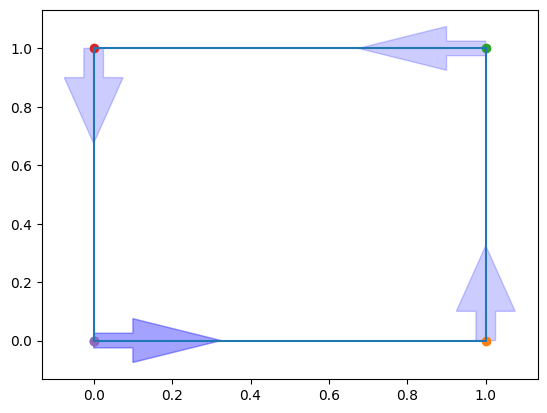

In [85]:
X_1_in_0, theta_1_in_0 = mat_from_xyt(*motion_from_0_to_1)

X_2_in_1, theta_2_in_1 = mat_from_xyt(*motion_from_1_to_2)

X_3_in_2, theta_3_in_2 = mat_from_xyt(*motion_from_2_to_3)

X_4_in_3, theta_4_in_3 = mat_from_xyt(*motion_from_3_to_4)


# The first pose is the origin.
Xs_and_thetas = []
Xs_and_thetas.append(mat_from_xyt(0,0,0))

# Add the next pose. It is specified in the origin frame, so we can add it as is.
Xs_and_thetas.append((X_1_in_0, theta_1_in_0))

# The following pose is specified in the i=1 frame. So we would need to transform it to the i=0 frame.
X_2_in_0 = X_1_in_0.dot(X_2_in_1)
theta_2_in_0 = theta_1_in_0 + theta_2_in_1
Xs_and_thetas.append((X_2_in_0, theta_2_in_0))

# Continue on your own!
# YOUR CODE HERE.

X_3_in_0 = X_2_in_0.dot(X_3_in_2)
theta_3_in_0 = theta_2_in_0 +  theta_3_in_2
Xs_and_thetas.append((X_3_in_0, theta_3_in_0))


X_4_in_0 = X_3_in_0.dot(X_4_in_3)
theta_4_in_0 = theta_3_in_0 +  theta_4_in_3
Xs_and_thetas.append((X_4_in_0, theta_4_in_0))


visualize_poses_in_world(Xs_and_thetas)

See what we did there? We converted all the relative transformations to the world frame and then plotted them.
We can do that in an independent function.

In [86]:
def compose_transformations(relative_Xs, relative_thetas):
    # The first pose is the origin.
    Xs_and_thetas_in_world = []
    Xs_and_thetas_in_world.append(mat_from_xyt(0,0,0))

    for X_new_in_previous, theta_new_in_previous in zip(relative_Xs, relative_thetas):
        X_previous_in_0, theta_previous_in_0 = Xs_and_thetas_in_world[-1]

        # The pose is specified in the previous frame. So we would need to transform it to the previous frame.
        X_new_in_0 = X_previous_in_0.dot(X_new_in_previous)
        theta_new_in_0 = theta_previous_in_0 + theta_new_in_previous
        Xs_and_thetas_in_world.append((X_new_in_0, theta_new_in_0))

    return Xs_and_thetas_in_world[1:]

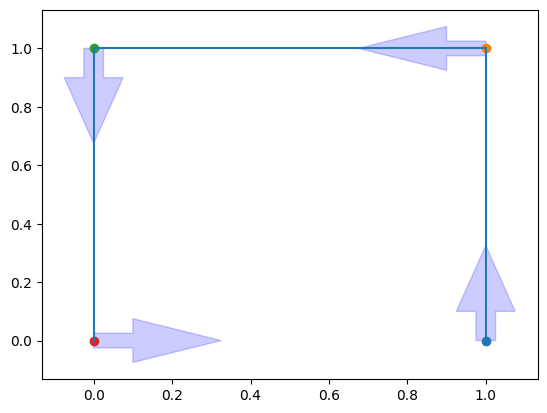

In [87]:
X_1_in_0, theta_1_in_0 = mat_from_xyt(*motion_from_0_to_1)
X_2_in_1, theta_2_in_1 = mat_from_xyt(*motion_from_1_to_2)
X_3_in_2, theta_3_in_2 = mat_from_xyt(*motion_from_2_to_3)
X_4_in_3, theta_4_in_3 = mat_from_xyt(*motion_from_3_to_4)

Xs_and_thetas_in_world = compose_transformations([X_1_in_0, X_2_in_1, X_3_in_2, X_4_in_3],
                                                 [theta_1_in_0, theta_2_in_1, theta_3_in_2, theta_4_in_3])

visualize_poses_in_world(Xs_and_thetas_in_world)


# Drift.

What if one of our measurements is wrong?

Say, the rotation component of $\theta^2_3 = \pi/4$

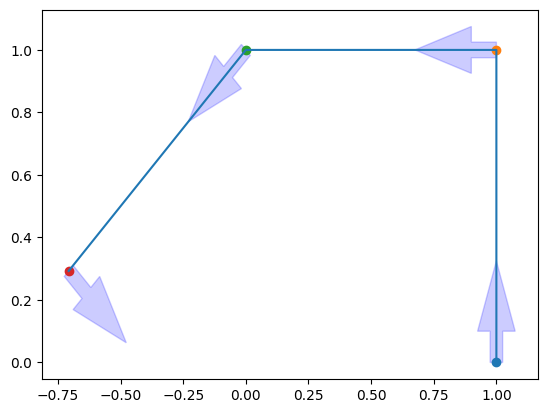

In [88]:

X_1_in_0, theta_1_in_0 = mat_from_xyt(*motion_from_0_to_1)

X_2_in_1, theta_2_in_1 = mat_from_xyt(*motion_from_1_to_2)
# CHANGE BELOW!
X_3_in_2, theta_3_in_2 = mat_from_xyt(1, 0, np.pi/4)

X_4_in_3, theta_4_in_3 = mat_from_xyt(*motion_from_3_to_4)



Xs_and_thetas_in_world = compose_transformations([X_1_in_0, X_2_in_1, X_3_in_2, X_4_in_3],
                                                 [theta_1_in_0, theta_2_in_1, theta_3_in_2, theta_4_in_3])

visualize_poses_in_world(Xs_and_thetas_in_world)


Let's now write the method that visualizes relative transformations.

In [89]:
def visualize_relative_poses(Xs_and_thetas):
    # First, transform all to the world frame.
    Xs_and_thetas_in_world = compose_transformations(*zip(*Xs_and_thetas))

    # Then proceed as was earlier.

    Xs, thetas = zip( *Xs_and_thetas_in_world)

    fig, axes = plt.subplots(1, 1)
    ax = axes
    arrow_length = 0.1
    arrow_width = 0.05
    
    xs, ys = [], []
    for ix, (X_i_in_0, theta) in enumerate(Xs_and_thetas):
        x =  X_i_in_0[0,2]
        y =  X_i_in_0[1,2]
        dt = theta
        ax.arrow(x, y, arrow_length * np.cos(dt), arrow_length * np.sin(dt), width=arrow_width, color = "b", alpha = 0.2)
        ax.scatter(x, y)
        xs.append(x)
        ys.append(y)
    ax.plot(xs, ys)
    
    plt.show()

## Landmarks.

So far we have discussed only one type of object in our world -- a robot. Our world is much richer than that, however! We can extend it to one more type of object, which we will call a landmark. Landmarks could be physical objects like doors, buildings, or even stickers. They need to be statics, i.e., not changing over time, and sufficiently unique such that a robot will be able to identify them. We assume that when a robot sees a landmark, it knows its current transformation to it exactly.

Specifically, if a robot sees a landmark $l$ at time step $i$, it immediately knows the transformation 

$$X^i_l, \theta^i_l$$

that is the position of the landmark at time $i$ in the frame of the robot.

Landmarks will be an integral part in our trajectory optimization pipeline. Let's see why!


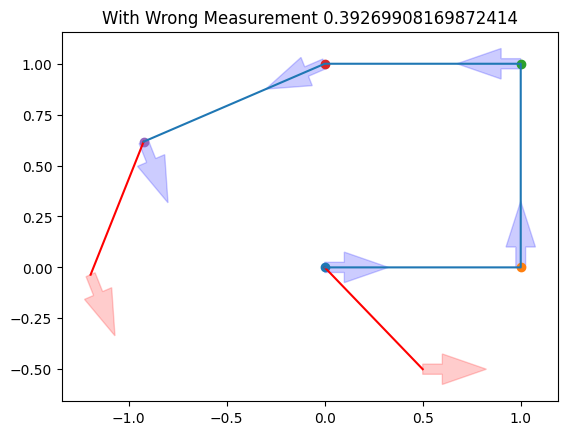

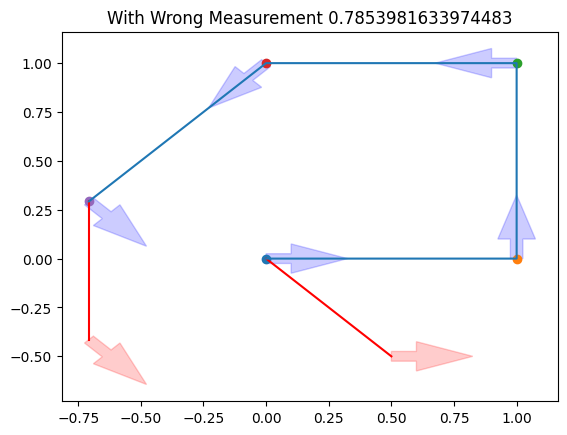

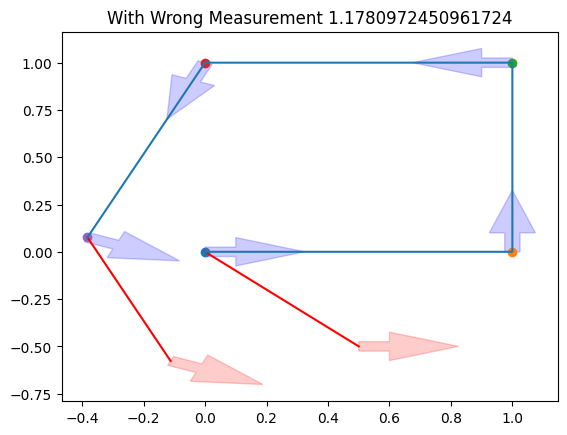

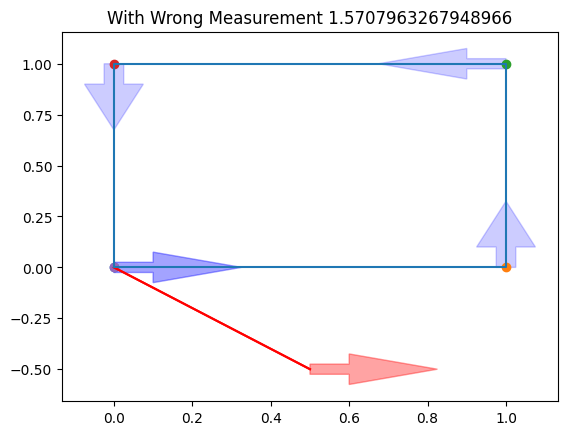

In [90]:
# Assume that a landmak l is present in the robot world.
# Also assume that the robot can observe the landmark at time i=0 and at time i=4.
# This yields the two transformations X^0_l and X^4_l.
# Since the robot is supposed to be in the same pose at both of those times, as we have written in the example, and the landmark is static in the world, then the observation shall be identical. Let's add it to the visualization.

def visualize_relative_poses(Xs_and_thetas, l_Xs_and_thetas, **kwargs):
    Xs_and_thetas_in_world = compose_transformations(*zip(*Xs_and_thetas))
    Xs, thetas = zip( *Xs_and_thetas_in_world)
    fig, axes = plt.subplots(1, 1)
    ax = axes
    arrow_length = 0.1
    arrow_width = 0.05
    
    xs, ys = [], []
    for ix, (X_i_in_0, theta) in enumerate(Xs_and_thetas_in_world):
        x =  X_i_in_0[0,2]
        y =  X_i_in_0[1,2]
        dt = theta
        ax.arrow(x, y, arrow_length * np.cos(dt), arrow_length * np.sin(dt), width=arrow_width, color = "b", alpha = 0.2)
        ax.scatter(x, y)
        xs.append(x)
        ys.append(y)

        if l_rel_Xs_and_thetas[ix] is not None:
            # Draw a line and arrow to the landmark.
            X_l_in_i, theta_l_in_i = l_rel_Xs_and_thetas[ix]
            X_l_in_0 = X_i_in_0.dot(X_l_in_i)
            theta_l_in_0 = dt + theta_l_in_i

            xl =  X_l_in_0[0,2]
            yl =  X_l_in_0[1,2]
            dt = theta
            ax.arrow(xl, yl, arrow_length * np.cos(theta_l_in_0), arrow_length * np.sin(theta_l_in_0), width=arrow_width, color = "r", alpha = 0.2)
            ax.plot([x, xl], [y, yl], c = 'r')

            

    
    ax.plot(xs, ys, )
    if "title" in kwargs:
        ax.set_title ( kwargs['title'])
    
    plt.show()

for wrong_theta in np.linspace(np.pi/8, np.pi/2, 4):

    X_0_in_0, theta_0_in_0 = mat_from_xyt(0,0,0)
    X_1_in_0, theta_1_in_0 = mat_from_xyt(*motion_from_0_to_1)

    X_2_in_1, theta_2_in_1 = mat_from_xyt(*motion_from_1_to_2)
    # CHANGE BELOW!
    X_3_in_2, theta_3_in_2 = mat_from_xyt(1, 0, wrong_theta)

    X_4_in_3, theta_4_in_3 = mat_from_xyt(*motion_from_3_to_4)


    Xs_and_thetas = zip([X_0_in_0 , X_1_in_0, X_2_in_1, X_3_in_2, X_4_in_3],
                                                    [theta_0_in_0, theta_1_in_0, theta_2_in_1, theta_3_in_2, theta_4_in_3])

    l_rel_Xs_and_thetas = [mat_from_xyt(0.5, -0.5, 0), None, None, None, mat_from_xyt(0.5, -0.5, 0)]

    plt_args = {"title": "With wrong measurement"}
    visualize_relative_poses(Xs_and_thetas, l_rel_Xs_and_thetas, title = f"With Wrong Measurement {wrong_theta}")

We immediately see that if the robot would place both landmark observations on the same point, then it could correct its trajectory!

## Update `Trajectory` Class

So what have we done so far?
1. We successfully converted relative poses between time-steps into the world frame (that we defined as the first-pose frame)
2. We visualized our poses.
3. We showed that one wrong pose could be detrimental to the trajectory as a whole.

Let's take a step back and re-examine what we want to do.
We are interested in recovering the motion of a robot in the world and correct any wrong measurements that have been recorded along the way. We'll do this by matching landmark observations to each other.

The `Trajectory` class will need to, for now,
1. Keep track of relative poses.
2. Keep track of observations of landmarks.
3. Visualize the current state of the system.

We'll begin by creating an object called an `Edge`. This object connects two robot poses with a rigid transformation. This transformation will also have a noise score associated with it. The higher the noise, the less confident the reading is.

In [91]:
class Edge():
    def __init__(self, i, j, xj, yj, tj, noise):
        self.i = i
        self.j = j
        # The following are in i frame.
        self.x = xj 
        self.y = yj
        self.t = tj
        self.noise = noise
    
    def __str__(self):
        return "i: %d, j: %d x: %d y: %d t: %d cost: %d" %(self.i, self.j, self.x, self.y, self.t, self.noise)


In [167]:

class Trajectory():
    def __init__(self) -> None:
        # Noise.
        self.ODOM_NOISE =     gtsam.noiseModel.Diagonal.Sigmas(np.array([0.3, 0.3, 0.1]))
        self.LANDMARK_NOISE = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.00003, 0.00003, 0.00003]))
        self.PRIOR_NOISE =    gtsam.noiseModel.Diagonal.Sigmas(np.array([0.00003, 0.00003, 0.00001]))
        # Optimization.
        self.graph = gtsam.NonlinearFactorGraph()
        self.graph_keys = {} # Maps node id to gtsam symbol.
        self.initial_estimate = gtsam.Values()
        self.prior_xyt = {} # Node id : (x,y,t)
        # Optimized poses.
        self.x_hat, self.t_hat = None, None

        # Keep track of edges. These lists are lists of Edge objects.
        self.edges = []
        self.landmarks = {}


    def add_edge(self, i, j, dx, dy, dt):
        """Add an edge to the pose graph.

        Args:
            i (int): the index of the parent-frame node. Edge is from x_i to x_j, all quantities in the reference frame of x_i. If i == j then this is an assignment, and the x,y,t quantities are in the map frame.
            dx (float): x axis displacement between x_i.x to this new observation.
            dy (float): y axis displacement between x_i.y to this new observation.
            dt (float): angle radians change between x_i.t to this new observation. In range [-pi, +pi].
        """
        # Decide what noise to use.
        if i == j:
            noise = self.PRIOR_NOISE
        else:
            noise = self.ODOM_NOISE

        # Record edge.
        self.edges.append(Edge(i, j, dx, dy, dt, noise))


    def add_landmark(self, i, j, dx, dy, dt):
        """Add an edge to the pose graph. This edge is between a robot pose i and a landmark with index j. j is the name of the landmark.

        Args:
            i (int): the index of the parent-frame node. Edge is from x_i to x_j, all quantities in the reference frame of x_i. If i == j then this is an assignment, and the x,y,t quantities are in the map frame.
            dx (float): x axis displacement between x_i.x to this new observation.
            dy (float): y axis displacement between x_i.y to this new observation.
            dt (float): angle radians change between x_i.t to this new observation. In range [-pi, +pi].
        """
        # Decide what noise to use.
        noise = self.LANDMARK_NOISE

        # Record edge.
        self.landmarks[i] = (Edge(i, j, dx, dy, dt, noise))


    def visualize(self, **kwargs):
        # Turn the list of edges to a list of relative transformation matrices and thetas.
        Xs_and_thetas = []
        edge_ixs = []
        X_and_theta_i_in_0 = {} # Keep track of the xy poses in the world. Mapping a node index to its (x,y) coordinate in the world frame.
        for edge in self.edges:
            dx = edge.x
            dy = edge.y
            dtheta = edge.t
            Xs_and_thetas.append(mat_from_xyt(dx, dy, dtheta))
            edge_ixs.append(edge.j)

        # Convert to the world frame.
        Xs_and_thetas_in_world = compose_transformations(*zip(*Xs_and_thetas))

        Xs, thetas = zip( *Xs_and_thetas_in_world)

        fig, axes = plt.subplots(1, 1)
        ax = axes
        arrow_length = 0.1
        arrow_width = 0.05
        
        # Edges are assumed to be consecutive.
        xs, ys = [], []
        for ix, (X_i_in_0, theta) in enumerate(Xs_and_thetas_in_world):
            edge_ix = edge_ixs[ix]
            x =  X_i_in_0[0,2]
            y =  X_i_in_0[1,2]
            dt = theta
            ax.arrow(x, y, arrow_length * np.cos(dt), arrow_length * np.sin(dt), width=arrow_width, color = "b", alpha = 0.2)
            ax.scatter(x, y)
            
            # Keep track of information.
            X_and_theta_i_in_0[edge_ix] = (X_i_in_0, theta)
            xs.append(x)
            ys.append(y)

        for i, ledge in self.landmarks.items():
            # Draw a line and arrow to the landmark.
            X_l_in_i, theta_l_in_i = mat_from_xyt(ledge.x, ledge.y, ledge.t)

            X_i_in_0 = X_and_theta_i_in_0[i][0]
            theta_i_in_0 = X_and_theta_i_in_0[i][1]

            X_l_in_0 = X_i_in_0.dot(X_l_in_i)
            theta_l_in_0 = theta_i_in_0 + theta_l_in_i

            xl =  X_l_in_0[0,2]
            yl =  X_l_in_0[1,2]
            xi =  X_i_in_0[0,2]
            yi =  X_i_in_0[1,2]
            ax.arrow(xl, yl, arrow_length * np.cos(theta_l_in_0), arrow_length * np.sin(theta_l_in_0), width=arrow_width, color = "r", alpha = 0.2)
            ax.plot([xi, xl], [yi, yl], c = 'r')

            
        ax.plot(xs, ys)
        if "title" in kwargs:
            ax.set_title ( kwargs['title'])
        

        # If there is an optimized result, then plot that too.
        if type(self.x_hat) is not type(None):
            landmark_ixs = [l.j for l in self.landmarks.values()]
            for i in range(len(self.t_hat)):
                ax.arrow(self.x_hat[2*i][0], self.x_hat[2*i + 1][0], arrow_length * np.cos(self.t_hat[i][0]), arrow_length * np.sin(self.t_hat[i][0]), width=arrow_width, color = 'k')
                
        plt.show()


    def create_initial_guess(self):
        self.prior_xyt = {}

        # Turn the list of edges to a list of relative transformation matrices and thetas.
        Xs_and_thetas = []
        edge_ixs = []
        X_and_theta_i_in_0 = {} # Keep track of the xy poses in the world. Mapping a node index to its (x,y) coordinate in the world frame.
        for edge in self.edges:
            dx = edge.x
            dy = edge.y
            dtheta = edge.t
            Xs_and_thetas.append(mat_from_xyt(dx, dy, dtheta))
            edge_ixs.append(edge.j)

        # Convert to the world frame.
        Xs_and_thetas_in_world = compose_transformations(*zip(*Xs_and_thetas))

        Xs, thetas = zip( *Xs_and_thetas_in_world)

        fig, axes = plt.subplots(1, 1)
        ax = axes
        arrow_length = 0.1
        arrow_width = 0.05
        
        # Edges are assumed to be consecutive.
        xs, ys = [], []
        for ix, (X_i_in_0, theta) in enumerate(Xs_and_thetas_in_world):
            edge_ix = edge_ixs[ix]
            x =  X_i_in_0[0,2]
            y =  X_i_in_0[1,2]
            dt = theta

            # Keep track of information.
            X_and_theta_i_in_0[edge_ix] = (X_i_in_0, theta)
            self.prior_xyt[edge_ix] = (x, y, dt)

        for i, ledge in self.landmarks.items():
            # Draw a line and arrow to the landmark.
            X_l_in_i, theta_l_in_i = mat_from_xyt(ledge.x, ledge.y, ledge.t)

            X_i_in_0 = X_and_theta_i_in_0[i][0]
            theta_i_in_0 = X_and_theta_i_in_0[i][1]

            X_l_in_0 = X_i_in_0.dot(X_l_in_i)
            theta_l_in_0 = theta_i_in_0 + theta_l_in_i

            xl =  X_l_in_0[0,2]
            yl =  X_l_in_0[1,2]
            self.prior_xyt[ledge.j] = (xl, yl, theta_l_in_0)


    def optimize(self):
        # Build the angles matrix and vector.
        # Initialize.
        if self.edges[0].i != self.edges[0].j:
            raise RuntimeError("First edge should be an assignment edge, not a cross-node edge.")
        
        # First, create all the graph keys. And the landmark keys.
        for k in range(0, len(self.edges)):
            edge = self.edges[k] # From i to j. xyt are for j and in i frame. 
            self.graph_keys[edge.j] = X(edge.j)
                
        for i in self.landmarks:
            edge = self.landmarks[i] # From i to j. xyt are for j and in i frame. 
            self.graph_keys[edge.j] = L(edge.j)

    
        # Second, add the priors for the poses to the graph.
        self.create_initial_guess()
        for j, (x,y,t) in self.prior_xyt.items():
            self.initial_estimate.insert(self.graph_keys[j], gtsam.Pose2(x,y,t))


        # Third, add the odometry edges.
        for k in range(0, len(self.edges)):
            edge = self.edges[k] # From i to j. xyt are for j and in i frame. 
            self.graph.add(
                gtsam.BetweenFactorPose2(self.graph_keys[edge.i], self.graph_keys[edge.j], gtsam.Pose2(edge.x, edge.y, edge.t), edge.noise))

        # Fourth, add the landmark edges.
        for i in self.landmarks:
            edge = self.landmarks[i] # From i to j. xyt are for j and in i frame. 

            # If this edge is an assignment (of a landmark), add it with a priorfactor.
            self.graph.add(
                    gtsam.BetweenFactorPose2(self.graph_keys[edge.i], self.graph_keys[edge.j], gtsam.Pose2(edge.x, edge.y, edge.t), edge.noise))
            

        # Print graph
        print("Factor Graph:\n{}".format(self.graph))
        # Print
        print("Initial Estimate:\n{}".format(self.initial_estimate))
        params = gtsam.LevenbergMarquardtParams()
        optimizer = gtsam.LevenbergMarquardtOptimizer(self.graph, self.initial_estimate,
                                                    params)
        result = optimizer.optimize()
        print("\nFinal Result:\n{}".format(result))
        print(result.atPose2(self.graph_keys[0]))

        self.x_hat = [ [ result.atPose2(self.graph_keys[j]).x(), result.atPose2(self.graph_keys[j]).y() ] for j in self.prior_xyt]
        self.x_hat = np.array([[item] for sublist in self.x_hat for item in sublist])
        self.t_hat = np.array([ [result.atPose2(self.graph_keys[j]).theta() ] for j in self.prior_xyt])
        return self.x_hat, self.t_hat


Factor Graph:
NonlinearFactorGraph: size: 7

Factor 0: BetweenFactor(x0,x0)
  measured:  (0, 0, 0)
  noise model: diagonal sigmas[3e-05; 3e-05; 1e-05];

Factor 1: BetweenFactor(x0,x1)
  measured:  (1, 0, 1.57079633)
  noise model: diagonal sigmas[0.3; 0.3; 0.1];

Factor 2: BetweenFactor(x1,x2)
  measured:  (1, 0, 1.57079633)
  noise model: diagonal sigmas[0.3; 0.3; 0.1];

Factor 3: BetweenFactor(x2,x3)
  measured:  (1, 0, 0.785398163)
  noise model: diagonal sigmas[0.3; 0.3; 0.1];

Factor 4: BetweenFactor(x3,x4)
  measured:  (1, 0, 1.57079633)
  noise model: diagonal sigmas[0.3; 0.3; 0.1];

Factor 5: BetweenFactor(x0,l5)
  measured:  (0.314149, -0.314149, 0)
isotropic dim=3 sigma=3e-05

Factor 6: BetweenFactor(x4,l5)
  measured:  (0.314149, -0.314149, 0)
isotropic dim=3 sigma=3e-05


Initial Estimate:
Values with 6 values:
Value l5: (gtsam::Pose2)
(-0.707106781, -0.151380558, -0.785398163)

Value x0: (gtsam::Pose2)
(0, 0, 0)

Value x1: (gtsam::Pose2)
(1, 0, 1.57079633)

Value x2: (gtsa

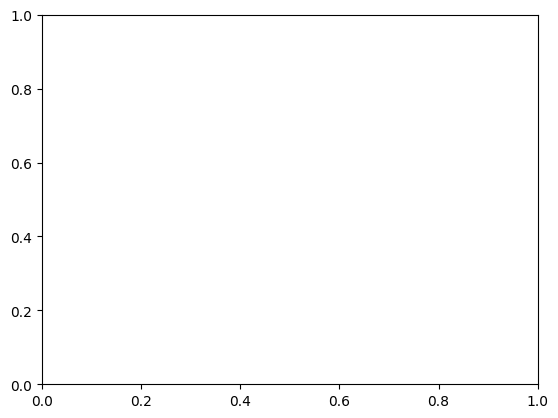

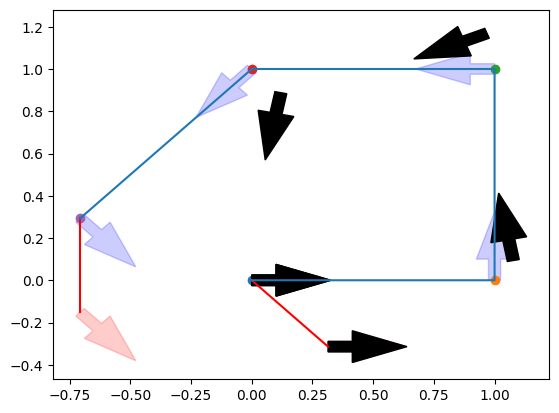

In [168]:
trajectory = Trajectory()
trajectory.add_edge(0,0,0, 0, 0)
trajectory.add_edge(0,1, 1, 0, np.pi/2)
trajectory.add_edge(1,2, 1, 0, np.pi/2)
trajectory.add_edge(2,3, 1, 0, np.pi/4)
trajectory.add_edge(3,4, 1, 0, np.pi/2)

# Give the landmarks negative identity names to avoid collisions between id's for landmarks and edges.
trajectory.add_landmark(0, 5, 0.314149, -0.314149, 0)
trajectory.add_landmark(4, 5, 0.314149, -0.314149, 0)

# trajectory.visualize()
trajectory.optimize()
trajectory.visualize()


## Using the class


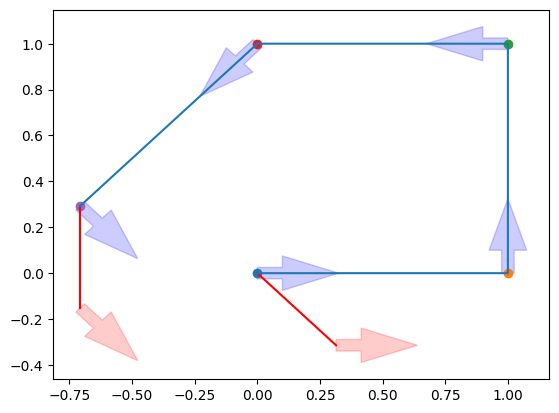

In [109]:
trajectory = Trajectory()
trajectory.add_edge(0,0,0, 0, 0)
trajectory.add_edge(0,1, 1, 0, np.pi/2)
trajectory.add_edge(1,2, 1, 0, np.pi/2)
trajectory.add_edge(2,3, 1, 0, np.pi/4)
trajectory.add_edge(3,4, 1, 0, np.pi/2)

# Give the landmarks negative identity names to avoid collisions between id's for landmarks and edges.
trajectory.add_landmark(0,-1, 0.314149, -0.314149, 0)
trajectory.add_landmark(4,-2, 0.314149, -0.314149, 0)

trajectory.visualize()

### Trajectory Optimization.

We are ready to attempt to optimize our trajectory!
The main idea in the optimization is that when a pose re-visits a landmark, it creates a constraint on the trajectory. This is called a loop-closure. 

In simple terms, we can think about the situation in the following way.
1. A robot left its base station and started moving in a room. 
2. The robot accumulated motion readings that slowly start to drift. When each one is slightly wrong, an error becomes larger and larger.
3. The robot "thinks" that it did not complete a full square in the room, but can see its base station being very close to it.
4. Because this observation is very confident (the robot does not mistake something else in the room for its base station), then it must be that the robot got back to its initial position.
5. Under the constraint, the robot slightly changes the belief over all of its past poses in such a way that each one changes as little as possible while the end pose reflects the base station-observation constraint.
6. Without such constraints, the robot will never be able to correct its current and past poses.

How does this look formally?

Let us denote observations of motion with $Z$. These are rigid transformations, similar to the one we denoted with $X$ earlier. Each motion step between time $i$ and time $i+1$ is encoded with a $Z^i_{i+1}$. The rotation associated with this motion will be denotes with $\zeta^i_{i+1}$. Remember that these are only estimates that we got from the robot sensors! The _real_ motion, which we do not know, will be denoted by $X$ and $\theta$ as before.

So how do we estimate the $X$'s and $\theta$'s given $Z$'s and $\zeta$'s?

For each pose in our graph, we'd like to find an estimated pose $\hat X^w_i$ such that all the edges that include this pose differ the least from their observations.

That is, we'd like to find $\hat X^w_{i}$ such that this is the  $\arg \min_{X} \Vert Z^i_{j} (X^i_{j})^{-1} \Vert ^2 \ \ \forall j \neq i$ over all the edges the involve pose $i$.

We can write this as an optimization.

Objective

$$
\min_{X} \sum_{i \in \text{edges}} \Vert Z^i_{j} (X^i_{j})^{-1} \Vert ^2 
$$

This is all find and well, however we immediately notice that this equation would yield $X^w_i = Z^w_i \ \ \forall i$ if the only constraints that would be used will be the odometry step readings.

Therefore, we should also add the information obtained by the landmark observations.
To do that, we'll create "virtual observations" for each re-observation of a landmark. For example, if a landmark $l$ was observed at time $i$ and at time $j$, then we can find the "virtual" edge between the robot's pose at time $i$ and at time $j$. 

$$Z^i_j = Z^i_l (Z^j_l)^{-1} = Z^i_l Z^l_j$$

This is great! So we don't even need to change our optimization expression from above. We simply add these edges to our collection of edges.

But.... we'd want to believe some edges more than we believe others, right? That is, a landmark re-observation gives us very high-confident information. Unlike motion steps which could be noisy. (This may or may not be true, depending on your setup.) 

To do that, we'll introduce an information matrix to the optimization expression. These matrices are square diagonal $3 \times 3$, and have entries that equal the inverse of the variance of the readings. This may sound like a mouthful, but all it really means is that the higher the number along the diagonal of the information matrix, the higher the cost would be for the estimated transformation $\hat X^i_{i+1}$ to deviate from the reading of the edge $Z^i_{i+1}$.

We'll denote the information matrix for an edge between node $i$ and node $j$ with $\Omega^i_j$.

Our final optimization yields

$$X^* = \arg \min_X \sum_{i,j \in \text{edges}}  \left(Z^i_{j} (X^i_{j})^{-1} \right)^\top \Omega^i_j  \left(Z^i_{j} (X^i_{j})^{-1} \right)

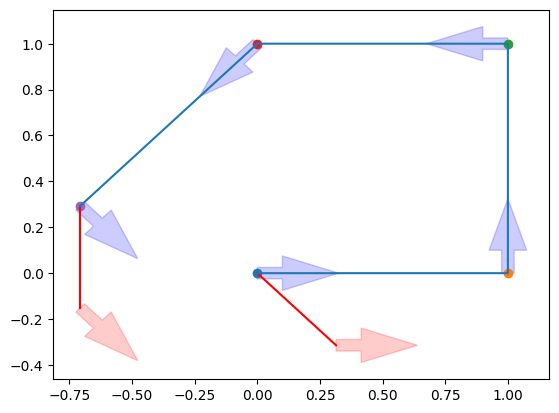

KeyError: 1

In [110]:
trajectory = Trajectory()
trajectory.add_edge(0,0,0, 0, 0)
trajectory.add_edge(0,1, 1, 0, np.pi/2)
trajectory.add_edge(1,2, 1, 0, np.pi/2)
trajectory.add_edge(2,3, 1, 0, np.pi/4)
trajectory.add_edge(3,4, 1, 0, np.pi/2)

# Give the landmarks negative identity names to avoid collisions between id's for landmarks and edges.
trajectory.add_landmark(0,100, 0.314149, -0.314149, 0)
trajectory.add_landmark(4, 100, 0.314149, -0.314149, 0)

trajectory.visualize()
trajectory.optimize()

### Optimization Primer

In this section we are not going to dive too deep into the background of optimization theory. In fact, we will almost completely leave the actual optimization of the pose graph  (the trajectory optimization) as a black box.

It is helpful, however, to understand what optimization is and how it could be solved.

In [94]:
# Least squares line fitting.


### Trajectory Optimization.

Formulation of cost function and analogy to least squares linear regression

provide code for optimization.